Setup & Imports
You'll need to log into huggingface and accept the terms of the licence for this model - see the model card for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 92.7 MB/s eta 0:00:00


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! mkdir "/root/.huggingface"

In [5]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [6]:
from base64 import b64encode

import numpy
import os
import torch

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
import torch.nn.functional as F
from transformers import logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
torch.cuda.is_available()

True

# CLIP image encoder

In [8]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy==6.1.1 regex==2022.4.24 tqdm==4.64.0 omegaconf==2.2.1 pytorch-lightning==1.6.3 &> /dev/null

from CLIP import clip # The clip model
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library


In [9]:
# Load in one of the models from CLIP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clip_model, clip_preprocess = clip.load('ViT-B/32', device=device)
perceptor = clip_model.requires_grad_(False)
# perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution) # 224px a side

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 161MiB/s]


224


In [10]:
def encode_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = clip_preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        encoded_image = clip_model.encode_image(image_tensor)

    return encoded_image

In [11]:
def encode_text(text):
    text_tensor = clip.tokenize([text]).to(device)

    with torch.no_grad():
        encoded_text = clip_model.encode_text(text_tensor)

    return encoded_text

In [12]:
data_path = '/content/drive/MyDrive/expa/layers_data/images/deduped_nfts/flatten'

In [13]:
%ls /content/drive/MyDrive/expa/layers_data/images/deduped_nfts


flatten/


In [14]:
# generate index
import numpy as np
import faiss
import pickle

In [36]:
index = faiss.IndexFlatL2(512)

In [37]:
id_index = faiss.IndexIDMap(index)

In [38]:
test_ids, index_ids = {}, {}

In [39]:
def get_recommendations(id):
  test_img = test_ids[id]
  print("Test image : ", test_img)
  file_path = os.path.join(data_path, str(test_img))
  img = Image.open(file_path).resize((224, 224))
  img.show()
  encoded_input = encode_image(file_path).cpu()
  k = 30
  distances, indices = id_index.search(encoded_input, k)
  for i in range(5):
    match_img = index_ids[indices[0][i]]
    print("Match ", i, " : ", match_img)
    img = Image.open(os.path.join(data_path, match_img)).resize((224, 224))
    img.show()

In [40]:
def image_search_for_prompt(prompt):
  print("Test prompt : ", prompt)

  encoded_input = encode_text(prompt).cpu()
  k = 30
  distances, indices = id_index.search(encoded_input, k)
  for i in range(5):
    match_img = index_ids[indices[0][i]]
    print("Match ", i, " : ", match_img)
    img = Image.open(os.path.join(data_path, match_img)).resize((224, 224))
    img.show()

In [41]:
def get_recommendations_img(test_img):
  print("Test image : ", test_img)
  file_path = os.path.join(data_path, str(test_img))
  img = Image.open(file_path).resize((224, 224))
  img.show()
  encoded_input = encode_image(file_path).cpu()
  k = 30
  distances, indices = id_index.search(encoded_input, k)
  for i in range(5):
    match_img = index_ids[indices[0][i]]
    print("Match ", i, " : ", match_img)
    img = Image.open(os.path.join(data_path, match_img)).resize((224, 224))
    img.show()

In [42]:
def image_search_for_prompt_similarity_top_match(prompt):
  print("Test prompt : ", prompt)

  encoded_input = encode_text(prompt).cpu()
  k = 30
  distances, indices = id_index.search(encoded_input, k)
  for i in range(1):
    print("<<<<<<<< Match {} >>>>>>>>>>>".format(i))
    get_recommendations_img(index_ids[indices[0][i]])

In [43]:

def train():
  with tqdm(total=len(os.listdir(data_path))) as pbar:
    id = 0
    with torch.no_grad():
      for file_name in os.listdir(data_path):
          file_path = os.path.join(data_path, file_name)
          pbar.update(1)
          try:
            # print(id, file_path)
            encoded = encode_image(file_path)
            # print(encoded.shape)
            if id % 10 == 0:
              test_ids[id] = file_name
            else:
              index_ids[id] = file_name
              id_index.add_with_ids(encoded.cpu(), np.array(id))
            id += 1
            # if id > 100:
            #   break
          except IOError:
            print(f"Error opening file: {file_path}")
            continue
          except:
            print(f"Error opening file: {file_path}")
            continue

In [44]:
train()

  0%|          | 0/1307 [00:00<?, ?it/s]

Error opening file: /content/drive/MyDrive/expa/layers_data/images/deduped_nfts/flatten/Bill of Rights_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_15613.jpeg


In [45]:
faiss.write_index(id_index, '/content/drive/MyDrive/expa/mini_mini_imagenet_data/nfts_flatten_clip.index')


In [46]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_nfts_flatten_test_ids.pkl', 'wb') as f:
  pickle.dump(test_ids, f)

In [47]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_nfts_flatten_index_ids.pkl', 'wb') as f:
  pickle.dump(index_ids, f)

In [48]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/mini_mini_imagenet_data/nfts_flatten_clip.index')


In [49]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_nfts_flatten_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)

In [50]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/clip_nfts_flatten_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [51]:
len(test_ids)

131

In [52]:
len(index_ids)

1175

In [53]:
test_ids

{0: 'Beatboxes #245_0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270_145000245.jpeg',
 10: 'Stuffed Pig_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_44180.jpeg',
 20: "Sleep Paralysis: Devil's Landscape_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_802542.jpeg",
 30: 'SuperlativeSS #7646_0xa7ee407497b2aeb43580cabe2b04026b5419d1dc_7646.jpeg',
 40: 'Rebels in Disguise #378_0x1ca1f5dc13f3204088993df413c81561dce72cfc_378.jpeg',
 50: 'BEARSELANCAR_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_161915.jpeg',
 60: 'Comet and Celery animation_0x03e28729b3ca515d98c9744a643a696c6ff98b0e_4.jpeg',
 70: 'PILLAGERS #3927_0x17f2fdd7e1dae1368d1fc80116310f54f40f30a9_3927.jpeg',
 80: 'This Kind of Saturday_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_466942.jpeg',
 90: 'cíclico (kA)_KT1WsXABBSFZUCP2fnmxHoQnBQuprj2wwn8z_12.jpeg',
 100: '#5365_0x65784d6f23de30a17122e96c0f0986c378ed6947_5365.jpeg',
 110: 'Expensive and Worthless #19_0x9bbaaea967d54a4df57eeeff97019d61d46485fd_19.jpeg',
 120: 'HUEPHORIA #113_0x1aaa3e26cf05f751f8efe0e3c81365d75cdba

Test image :  This Kind of Saturday_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_466942.jpeg


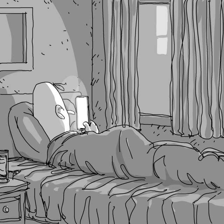

Match  0  :  Attention_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_186830.jpeg


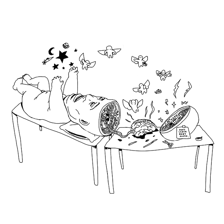

Match  1  :  Krasina 2022. Bedroom _KT1WqCUxcb77ofJYJcunffPu4u7MYHnyEzgB_0.jpeg


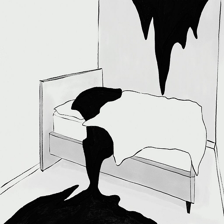

Match  2  :  Bedroom Nostalgia 12_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_137108.jpeg


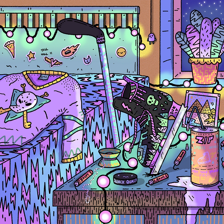

Match  3  :  #119_0x7418129711194399e55c9eebb8d1b8fcb3811924_119.jpeg


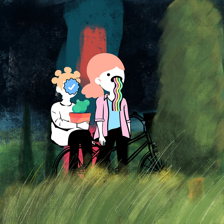

Match  4  :  GOOD MORNING WALNUT STREET_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_207966.jpeg


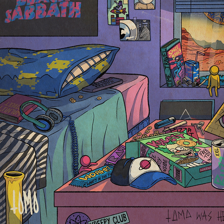

In [55]:
get_recommendations(80)

Test image :  Sleep Paralysis: Devil's Landscape_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_802542.jpeg


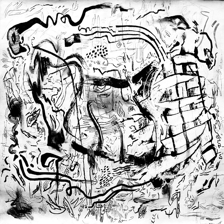

Match  0  :  dAcidMonster_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_625784.jpeg


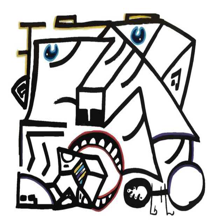

Match  1  :  are_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_224895.jpeg


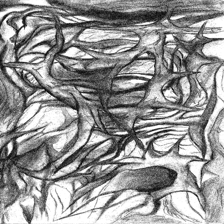

Match  2  :  Home_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_139023.jpeg


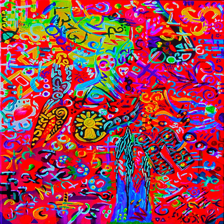

Match  3  :  Crocodile's Revenge on the Black Hole_KT1SE21dfZjLBW6i1JXjd9UTz6DFwwXohp34_8.jpeg


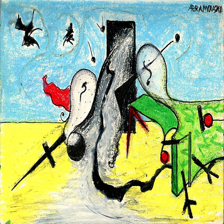

Match  4  :  Celestial_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_764908.jpeg


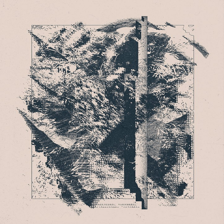

In [56]:
get_recommendations(20)

Test image :  Rug Radio Membership Pass_0xd1d411d2da363144248b98adab453aa3b19ccf04_9485.jpeg


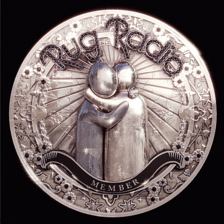

Match  0  :  Pesci Pennies_KT1DkWtadxAyN85cPsowv4escMnt5tur9h2p_0.jpeg


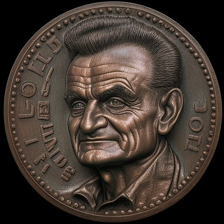

Match  1  :  Claro_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_213081.jpeg


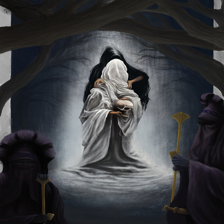

Match  2  :  Venus_KT1TeZGnL6TBdbXLQ8TAC7adcGCjrBkDdRXv_10.jpeg


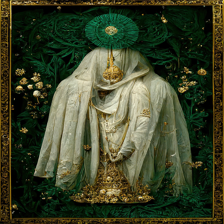

Match  3  :  I guess I'll see you next lifetime_0x009c5b7ff119972e3437b51c4f94addb8dbb2bcd_8.jpeg


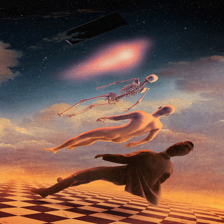

Match  4  :  ICONOCLASH #248_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_800930 (1).jpeg


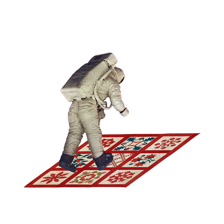

In [57]:
get_recommendations(280)

Test image :  That Time Again_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_505624.jpeg


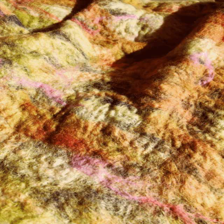

Match  0  :  M01_KT1Sr2ThWkAzguYAJSG31keV4X7py2eV9EwT_0.jpeg


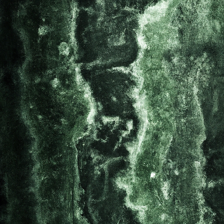

Match  1  :  salt flats #2_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_116816.jpeg


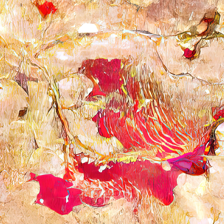

Match  2  :  A pink depth _KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_605136.jpeg


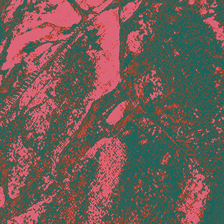

Match  3  :  Sp81222_KT1CCTLbM9kuT6FnfoKZgFvm9HdutHjG7CsH_2.jpeg


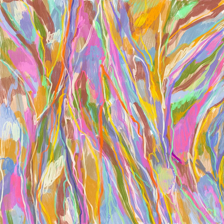

Match  4  :  Infinite #415_0xa7f767865fce8236f71adda56c60cf2e91dadc00_415.jpeg


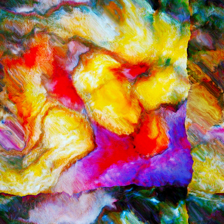

In [58]:
get_recommendations(780)

Test prompt :  skull and bones
<<<<<<<< Match 0 >>>>>>>>>>>
Test image :  B2B Open Edition 391_0xe4d5d6d6eda2fd5c3545ff4f0ec7d06075de9703_441.jpeg


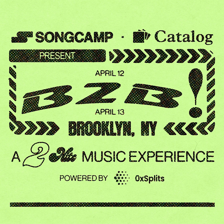

Match  0  :  B2B Open Edition 391_0xe4d5d6d6eda2fd5c3545ff4f0ec7d06075de9703_441.jpeg


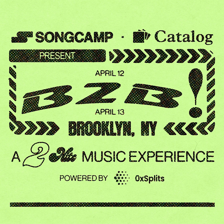

Match  1  :  Deadfrenz Lab Access Pass (DF)_0x090f688f0c11a8671c47d833af3cf965c30d3c35_2.jpeg


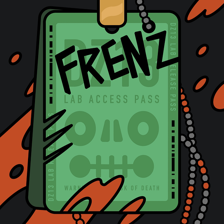

Match  2  :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


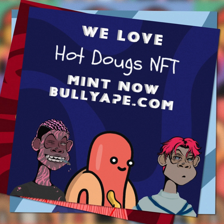

Match  3  :  ColorPencil Club - BAYC_0x6315d09bc75ee00b767142c05265eeb180765093_5794.jpeg


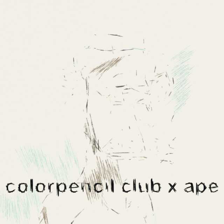

Match  4  :  Room 04_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_147848.jpeg


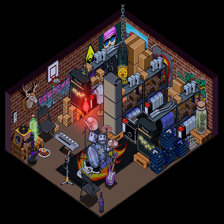

In [63]:
image_search_for_prompt_similarity_top_match("skull and bones")

Test prompt :  books on shelf
<<<<<<<< Match 0 >>>>>>>>>>>
Test image :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


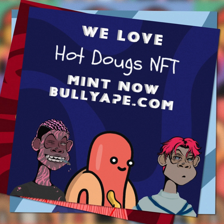

Match  0  :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


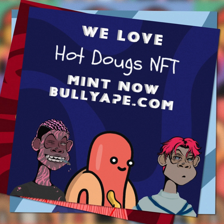

Match  1  :  BULLY APES_0xc9e4314d26accde82bac71ced0263b948cde73c4_3000081.jpeg


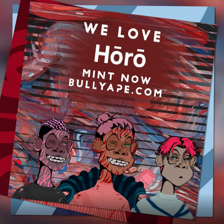

Match  2  :  Gutter Punks Flyer - MURI_0x992274bfa5f32d2ca8a283dd80ac335882ab19fa_1955.jpeg


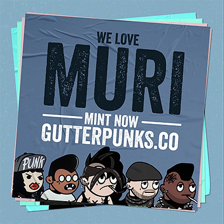

Match  3  :  Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_340282366920938463463374607431768211476 (1).jpeg


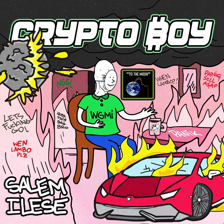

Match  4  :  Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_340282366920938463463374607431768211476.jpeg


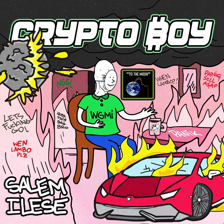

In [66]:
image_search_for_prompt_similarity_top_match("books on shelf")

Test prompt :  birds flying
<<<<<<<< Match 0 >>>>>>>>>>>
Test image :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


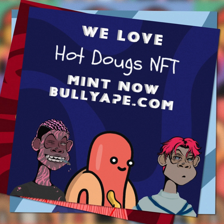

Match  0  :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


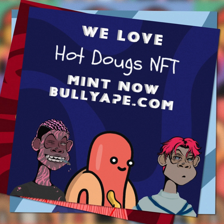

Match  1  :  BULLY APES_0xc9e4314d26accde82bac71ced0263b948cde73c4_3000081.jpeg


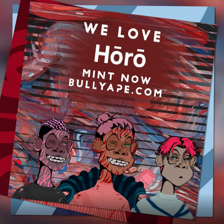

Match  2  :  Gutter Punks Flyer - MURI_0x992274bfa5f32d2ca8a283dd80ac335882ab19fa_1955.jpeg


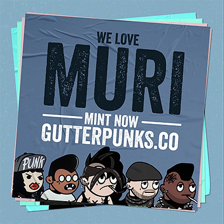

Match  3  :  Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_340282366920938463463374607431768211476 (1).jpeg


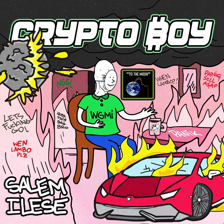

Match  4  :  Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_340282366920938463463374607431768211476.jpeg


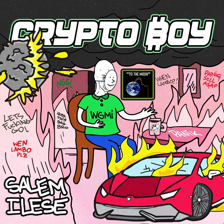

In [62]:
image_search_for_prompt_similarity_top_match("birds flying")

Test prompt :  food on plate
<<<<<<<< Match 0 >>>>>>>>>>>
Test image :  GREASY_0xedc227ad7fef4a2c6dbc2303a5732087314a4ce9_8.jpeg


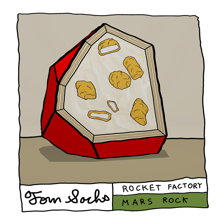

Match  0  :  GREASY_0xedc227ad7fef4a2c6dbc2303a5732087314a4ce9_8.jpeg


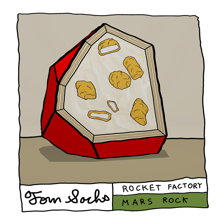

Match  1  :  Tasty Toasty #4189_0x6264e45d7118f727314633d8e4c503d51d3b0d03_4189.jpeg


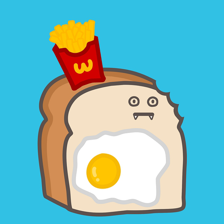

Match  2  :  trash inc #206_0x7b470a99ae6802eac80c78d775355f7f467c0cf1_206.jpeg


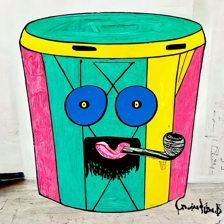

Match  3  :  Cursed Cathedral of The Innocent Witch Foozeb _0xbff184118bf575859dc6a236e8c7c4f80dc7c25c_623.jpeg


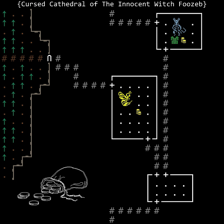

Match  4  :  Verified Artist Badge_KT1Xf44LpwrA7oBcB3VwWTtUBP1eNRaNnWeh_10.jpeg


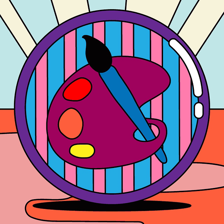

In [64]:
image_search_for_prompt_similarity_top_match("food on plate")

Test prompt :  man running
<<<<<<<< Match 0 >>>>>>>>>>>
Test image :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


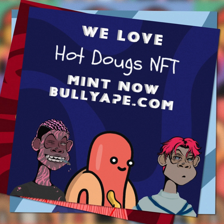

Match  0  :  BULLY APES_0x4f665e87e14e04533ed8483024bb1a92e402ed55_1340.jpeg


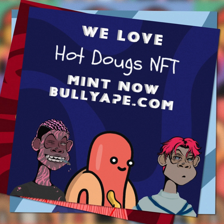

Match  1  :  BULLY APES_0xc9e4314d26accde82bac71ced0263b948cde73c4_3000081.jpeg


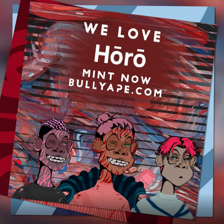

Match  2  :  Gutter Punks Flyer - MURI_0x992274bfa5f32d2ca8a283dd80ac335882ab19fa_1955.jpeg


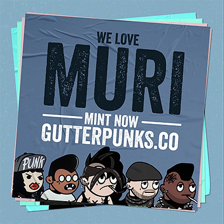

Match  3  :  Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_340282366920938463463374607431768211476 (1).jpeg


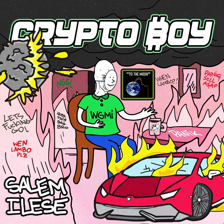

Match  4  :  Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_340282366920938463463374607431768211476.jpeg


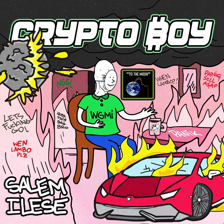

In [67]:
image_search_for_prompt_similarity_top_match("man running")